jupyter notebook --NotebookApp.iopub_data_rate_limit=5368709120

In [1]:
# Reset memory
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import warnings
warnings.filterwarnings("ignore")

import mlflow

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import spearmanr
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

In [4]:
import xgboost as XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import XGBClassifier

In [5]:
path=('C:/Users/td/Documents/3. FORMATIONS/2 - OPENCLASSROOMS/Data Science/7. Projet 7/0. Data/')

In [6]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [7]:
df=main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 52s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 65s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 31s
Installments payments df shape: (339587, 26)
Process installments payments - done in 77s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 43s


In [8]:
np.unique(df.dtypes)

array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

In [9]:
df.shape

(356251, 798)

In [10]:
inf_bool = np.isinf(df)
inf_indices = np.where(inf_bool)
inf_indices

(array([  5687,   5687,   5687,  60475,  60475,  60475,  79075,  79075,
         79075,  89015,  89015,  89015,  98506,  98506,  98506, 126765,
        126765, 126765, 128788, 128788, 128788, 140423, 140423, 140423,
        152084, 152084, 152084, 167133, 167133, 167133, 199099, 199099,
        199099, 201082, 201082, 201082, 201082, 236160, 236160, 236160,
        238377, 238377, 238377, 272825, 272825, 272825, 277958, 277958,
        277958, 287296, 287296, 287296, 292848, 292848, 292848, 305369,
        305369, 305369, 310335, 310335, 310335], dtype=int64),
 array([638, 639, 640, 638, 639, 640, 638, 639, 640, 638, 639, 640, 638,
        639, 640, 638, 639, 640, 638, 639, 640, 638, 639, 640, 638, 639,
        640, 638, 639, 640, 638, 639, 640, 374, 375, 593, 594, 638, 639,
        640, 638, 639, 640, 638, 639, 640, 638, 639, 640, 638, 639, 640,
        638, 639, 640, 638, 639, 640, 638, 639, 640], dtype=int64))

In [11]:
df[np.isinf(df)] = np.nan

# tester la methode iterative

In [12]:
df=df[~df['TARGET'].isna()]

In [13]:
df.fillna(df.median(), inplace=True)

In [14]:
df.isna().sum()

index                               0
SK_ID_CURR                          0
TARGET                              0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
                                   ..
CC_NAME_CONTRACT_STATUS_nan_MAX     0
CC_NAME_CONTRACT_STATUS_nan_MEAN    0
CC_NAME_CONTRACT_STATUS_nan_SUM     0
CC_NAME_CONTRACT_STATUS_nan_VAR     0
CC_COUNT                            0
Length: 798, dtype: int64

In [15]:
df=df.drop(['index'],axis=1)

# Imbalanced class

In [16]:
# summarize the class distribution
from collections import Counter

target = df.values[:,2]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=105059, Percentage=34.165%
Class=1, Count=202448, Percentage=65.835%


In [17]:
X=df.drop(['TARGET'],axis=1)
y=df['TARGET']

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [19]:
# Séparation des données en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Équilibrage des données en utilisant SMOTE
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_resampled, y_train_resampled= pipeline.fit_resample(X, y)



In [20]:
y_train_resampled.value_counts()/len(y_train_resampled)

0.0    0.666667
1.0    0.333333
Name: TARGET, dtype: float64

In [ ]:
X_train_resampled

# Dummy

Before we can improve our model, we need a baseline.

In [22]:
clf_dummy = DummyClassifier(random_state=39) 
#establishing random_state for reproducibility
clf_dummy.fit(X_train_resampled, y_train_resampled)
y_pred = clf_dummy.predict(X_test)

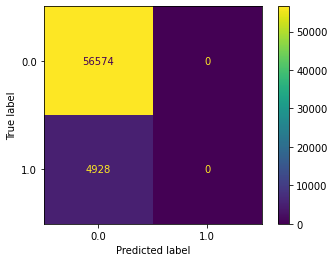

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

## MLFLOW UI

In [24]:
#Score metier
def score_metier(y_test,y_pred):
    cost_fn = 10 ### coût d’un FN est dix fois supérieur au coût d’un FP
    cost_fp = 1
    # Matrice de confusion pour calculer le nombre de FN et de FP ## Voir proba avec seuil
    confusion_matrix = np.array([[np.sum((y_pred == 0) & (y_test == 0)), np.sum((y_pred == 1) & (y_test == 0))],
                                 [np.sum((y_pred == 0) & (y_test == 1)), np.sum((y_pred == 1) & (y_test == 1))]])
    score_metier = cost_fp * confusion_matrix[0,1] + cost_fn * confusion_matrix[1,0]
    return score_metier
    

In [25]:
# Pipeline for numerical and categorical pipelines

preprocessor=PowerTransformer(method='yeo-johnson',standardize=True)


In [26]:
param_log_reg = {
    "model__penalty": [ "l2"],
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__tol": [0.0001, 0.001, 0.01],
    "model__solver": ["liblinear", "saga"],
    "model__max_iter": [100, 200, 500, 1000]
}

param_Xgboost = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.1, 0.2, 0.3]
}

In [27]:
# # Dictionnaire de classifieurs 
# models_ = { 'Logistic Regression':{'model':LogisticRegression(),'params':param_log_reg},
#             'Xgboost':{'model': XGBClassifier(), 'params':param_Xgboost}
#               }

In [28]:
cv = StratifiedKFold(n_splits=5)

In [ ]:
# Dictionnaire de classifieurs 
models_ = { 'Logistic Regression':{'model':LogisticRegression(),'params':param_log_reg},
            'Xgboost':{'model': XGBClassifier(), 'params':param_Xgboost}
              }
mlflow.sklearn.autolog()

for model_ in models_.keys():
    experiment_name = model_
    mlflow.set_experiment(experiment_name)
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', models_[model_]['model'])])
    gscv = GridSearchCV(pipe, param_grid=models_[model_]['params'], cv=cv,scoring='accuracy')
    gscv.fit(X_train_resampled,y_train_resampled)
    
    for i, params in enumerate(gscv.cv_results_["params"]):
        with mlflow.start_run(run_name=f"Hyperparamètre {i + 1}"):
            mlflow.log_params(params)
            mlflow.log_metric("Score de validation", gscv.cv_results_["mean_test_score"][i])

            gscv.set_params(**params)
            gscv.fit(X_train_resampled, y_train_resampled)

            y_pred = gscv.predict(X_test)
        
        # Evaluate the model on the test data

        probabilities = pipe.predict_proba(X_test)
        #Score metier
        threshold = 0.7
        y_pred = np.where(probabilities[:, 1] >= threshold, 1, 0)

        cost_fn = 10  # coût d’un FN est dix fois supérieur au coût d’un FP
        cost_fp = 1
        # Matrice de confusion pour calculer le nombre de FN et de FP ## Voir proba avec seuil
        confusion_matrix = np.array([[np.sum((y_pred == 0) & (y_test == 0)), np.sum((y_pred == 1) & (y_test == 0))],
                                     [np.sum((y_pred == 0) & (y_test == 1)), np.sum((y_pred == 1) & (y_test == 1))]])
        score_metier = cost_fp * confusion_matrix[0,1] + cost_fn * confusion_matrix[1,0]

        # Log the model
        mlflow.sklearn.log_model(pipe, "model")

        # score_metier as metrics
        accuracy = round(accuracy_score(y_test, y_pred), 4)
        auc = roc_auc_score(y_test, y_pred)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("score_metier", score_metier)

mlflow.end_run()

2023/02/10 20:53:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0c37cb393226450ab1d2b3cef4d41d1d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [ ]:
# ## Erase experiment
# from mlflow.tracking import MlflowClient

# client = MlflowClient()
# experiments = client.search_experiments("DummyClassifier")
# for experiment in experiments:
#     client.delete_experiment(experiment.experiment_id)


In [21]:
from sklearn.linear_model import LogisticRegression
model_saved=LogisticRegression()

In [22]:
model_saved.fit(X,y)

LogisticRegression()

In [23]:
log_reg_pickle = open('model_saved_loan.pickle', 'wb')

pickle.dump(model_saved, log_reg_pickle)

log_reg_pickle.close()

In [24]:
## Exemple pour test
customer_info=df[['SK_ID_CURR','AMT_CREDIT','AMT_ANNUITY']]

In [25]:
cust_info_pickle=open('customers_info','wb')
pickle.dump(customer_info,cust_info_pickle)
cust_info_pickle.close()

In [26]:
customer_info[customer_info['SK_ID_CURR']==100002]['AMT_CREDIT']

0    406597.5
Name: AMT_CREDIT, dtype: float64

In [ ]:
y_100002=model_saved.predict(customer_info[customer_info['SK_ID_CURR']==100002])

In [28]:
model_saved.get_score(importance_type='gain')

AttributeError: 'LogisticRegression' object has no attribute 'get_score'

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

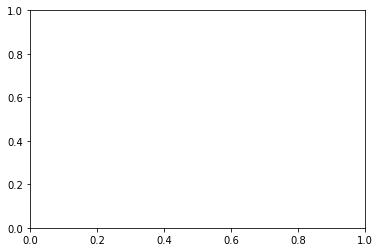

In [27]:
fig, ax = plt.subplots()

ax = sns.barplot(model_saved.get_score(eature_importances_, df.columns)

plt.title('Which features are the most important for species prediction?')

plt.xlabel('Importance')

plt.ylabel('Feature')